# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp, bootstrap_seasonal_mean_pr_change_samples
from mlde_analysis.distribution import normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS
from mlde_analysis.display import VAR_RANGES, pretty_table
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() }

PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

In [ ]:
CCS_SEASONS = ["DJF", "MAM", "JJA", "SON"]

In [ ]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())]).sel(model=[m for ms in CCS_MODELS.values() for m in ms.keys()])

## Seasonal domain mean changes

In [ ]:
def mean_change(ds):
    hist_stat = ds.where(ds["time_period"] == "historic", drop=True).mean(dim=...)
    fut_stat = ds.where(ds["time_period"] == "future", drop=True).mean(dim=...)
    return fut_stat - hist_stat

def per_model_change(ds):
    return ds.groupby("model").map(functools.partial(mean_change))

for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)
    hist_cpm_means = CCS_DS[f"target_{var}"].where(CCS_DS[f"target_{var}"]["time_period"] == "historic", drop=True).groupby("time.season").mean(dim=...)
        
    cpm_change = CCS_DS[f"target_{var}"].groupby("time.season").map(mean_change)
    
    emu_change = CCS_DS[f"pred_{var}"].groupby("time.season").map(per_model_change)
    
    table_ds = xr.merge([
        (100*cpm_change/np.abs(hist_cpm_means)).rename("CPM change (% of CPM historic)"),
        (100*emu_change/np.abs(hist_cpm_means)).rename("Emulator change (% of CPM historic)"),
        (100*(emu_change-cpm_change)/np.abs(cpm_change)).rename(f"Difference (% of CPM change)"),
        (100*(emu_change-cpm_change)/np.abs(hist_cpm_means)).rename(f"Difference (% of CPM historic)"),
    ])

    pretty_table(table_ds)

### pr

CPM change (% of CPM historic) 
 Emulator change (% of CPM historic) 
 Difference (% of CPM change) 
 Difference (% of CPM historic) 
 
 
 season 
 model 
   
   
   
   
 
 
 
 
 DJF 
 CPMGEM_GCM 
 23.1 
 17.2 
 -25.5 
 -5.9 
 
 
 CPMGEM_cCPM 
 23.1 
 18.3 
 -20.9 
 -4.8 
 
 
 JJA 
 CPMGEM_GCM 
 -40.0 
 -39.2 
 2.0 
 0.8 
 
 
 CPMGEM_cCPM 
 -40.0 
 -39.4 
 1.5 
 0.6 
 
 
 MAM 
 CPMGEM_GCM 
 6.2 
 2.4 
 -60.8 
 -3.8 
 
 
 CPMGEM_cCPM 
 6.2 
 4.3 
 -30.9 
 -1.9 
 
 
 SON 
 CPMGEM_GCM 
 -3.9 
 -8.4 
 -113.8 
 -4.5 
 
 
 CPMGEM_cCPM 
 -3.9 
 -6.3 
 -59.2 
 -2.3

### Significance testing on seasonal domain mean changes

With bootstrapped distribution and CIs

#### pr

##### CPMGEM_GCM

###### DJF

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,56.66,33.41,-41.29,13.08,7.71,-9.53
0.975,143.88,116.69,-9.78,33.21,26.93,-2.26


###### MAM

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-76.79,-136.31,-133.8,-4.76,-8.45,-8.29
0.975,276.47,212.06,12.8,17.13,13.14,0.79


###### JJA

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-130.13,-127.0,-14.19,-52.07,-50.82,-5.68
0.975,-68.52,-68.8,17.76,-27.42,-27.53,7.11


###### SON

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-391.34,-526.15,-239.85,-15.37,-20.67,-9.42
0.975,194.06,97.64,13.18,7.62,3.84,0.52


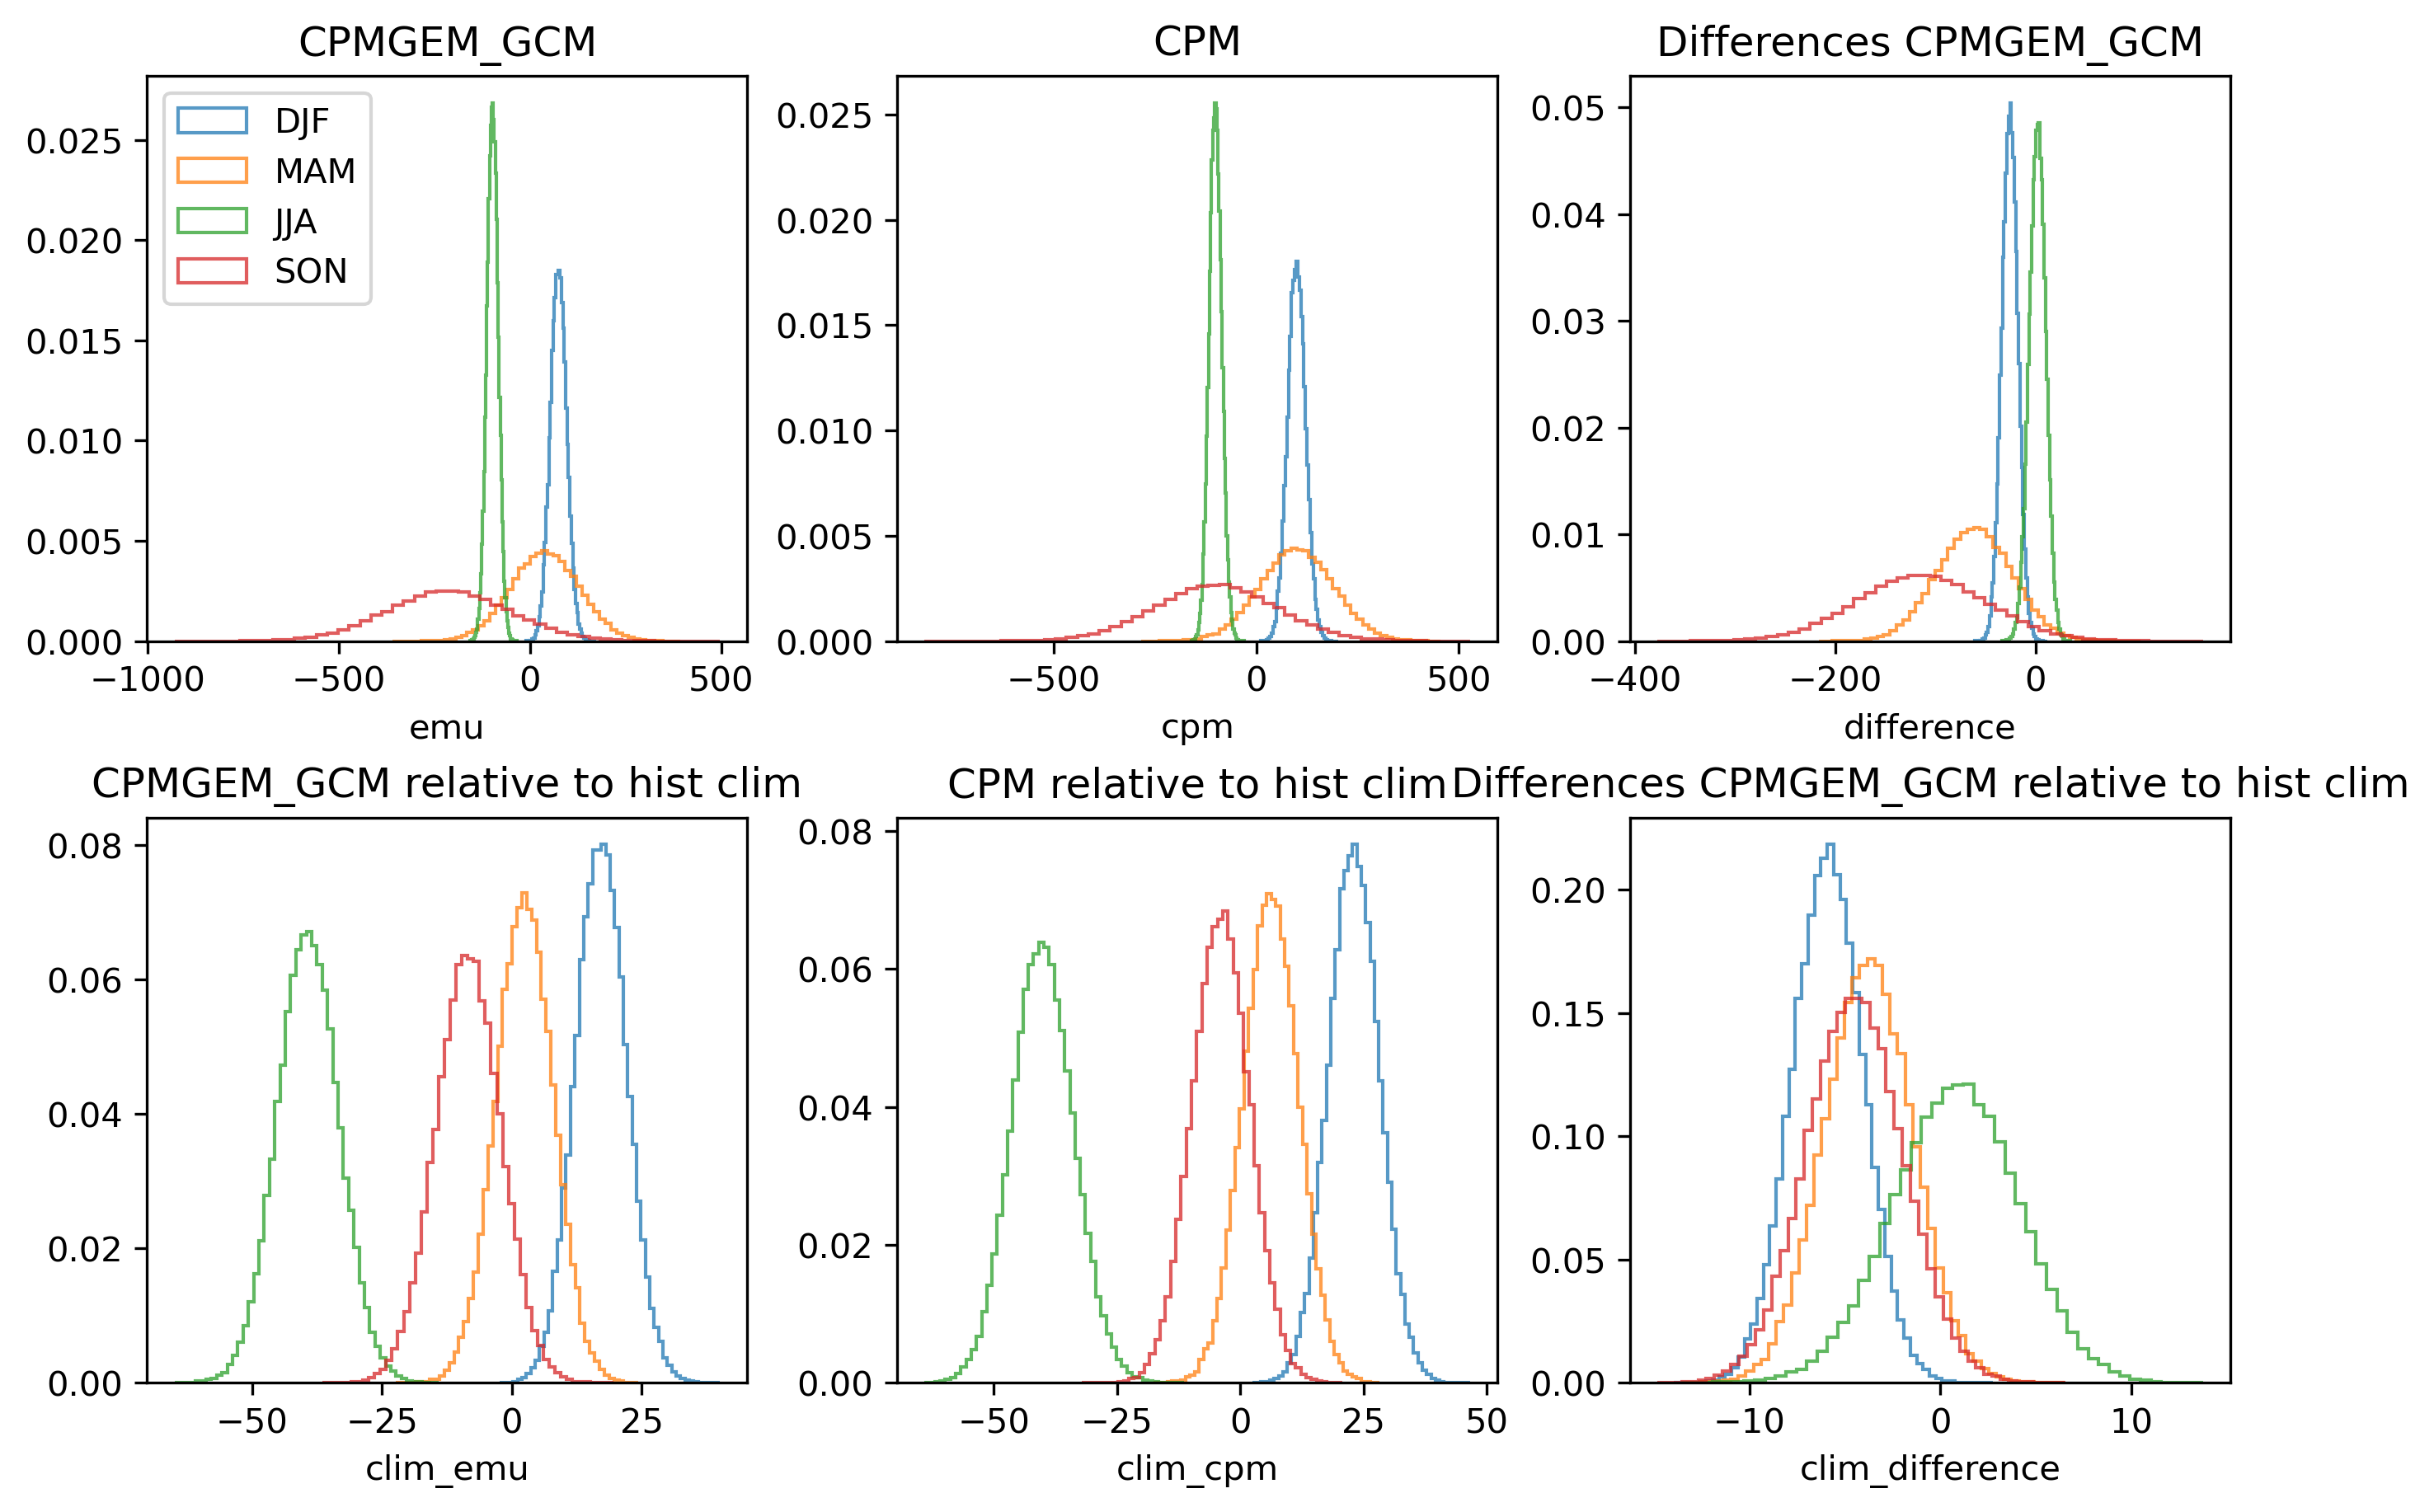

##### CPMGEM_cCPM

###### DJF

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,56.70,36.82,-33.35,13.09,8.50,-7.70
0.975,144.06,122.04,-8.58,33.25,28.17,-1.98


###### MAM

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-77.90,-105.24,-77.66,-4.83,-6.52,-4.81
0.975,276.92,242.30,15.54,17.16,15.01,0.96


###### JJA

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-130.3,-126.01,-7.11,-52.14,-50.42,-2.85
0.975,-68.4,-70.61,9.65,-27.37,-28.25,3.86


###### SON

,cpm,emu,difference,clim_cpm,clim_emu,clim_difference
quantile,,,,,,
0.025,-395.63,-443.18,-129.07,-15.54,-17.41,-5.07
0.975,195.29,123.49,8.82,7.67,4.85,0.35


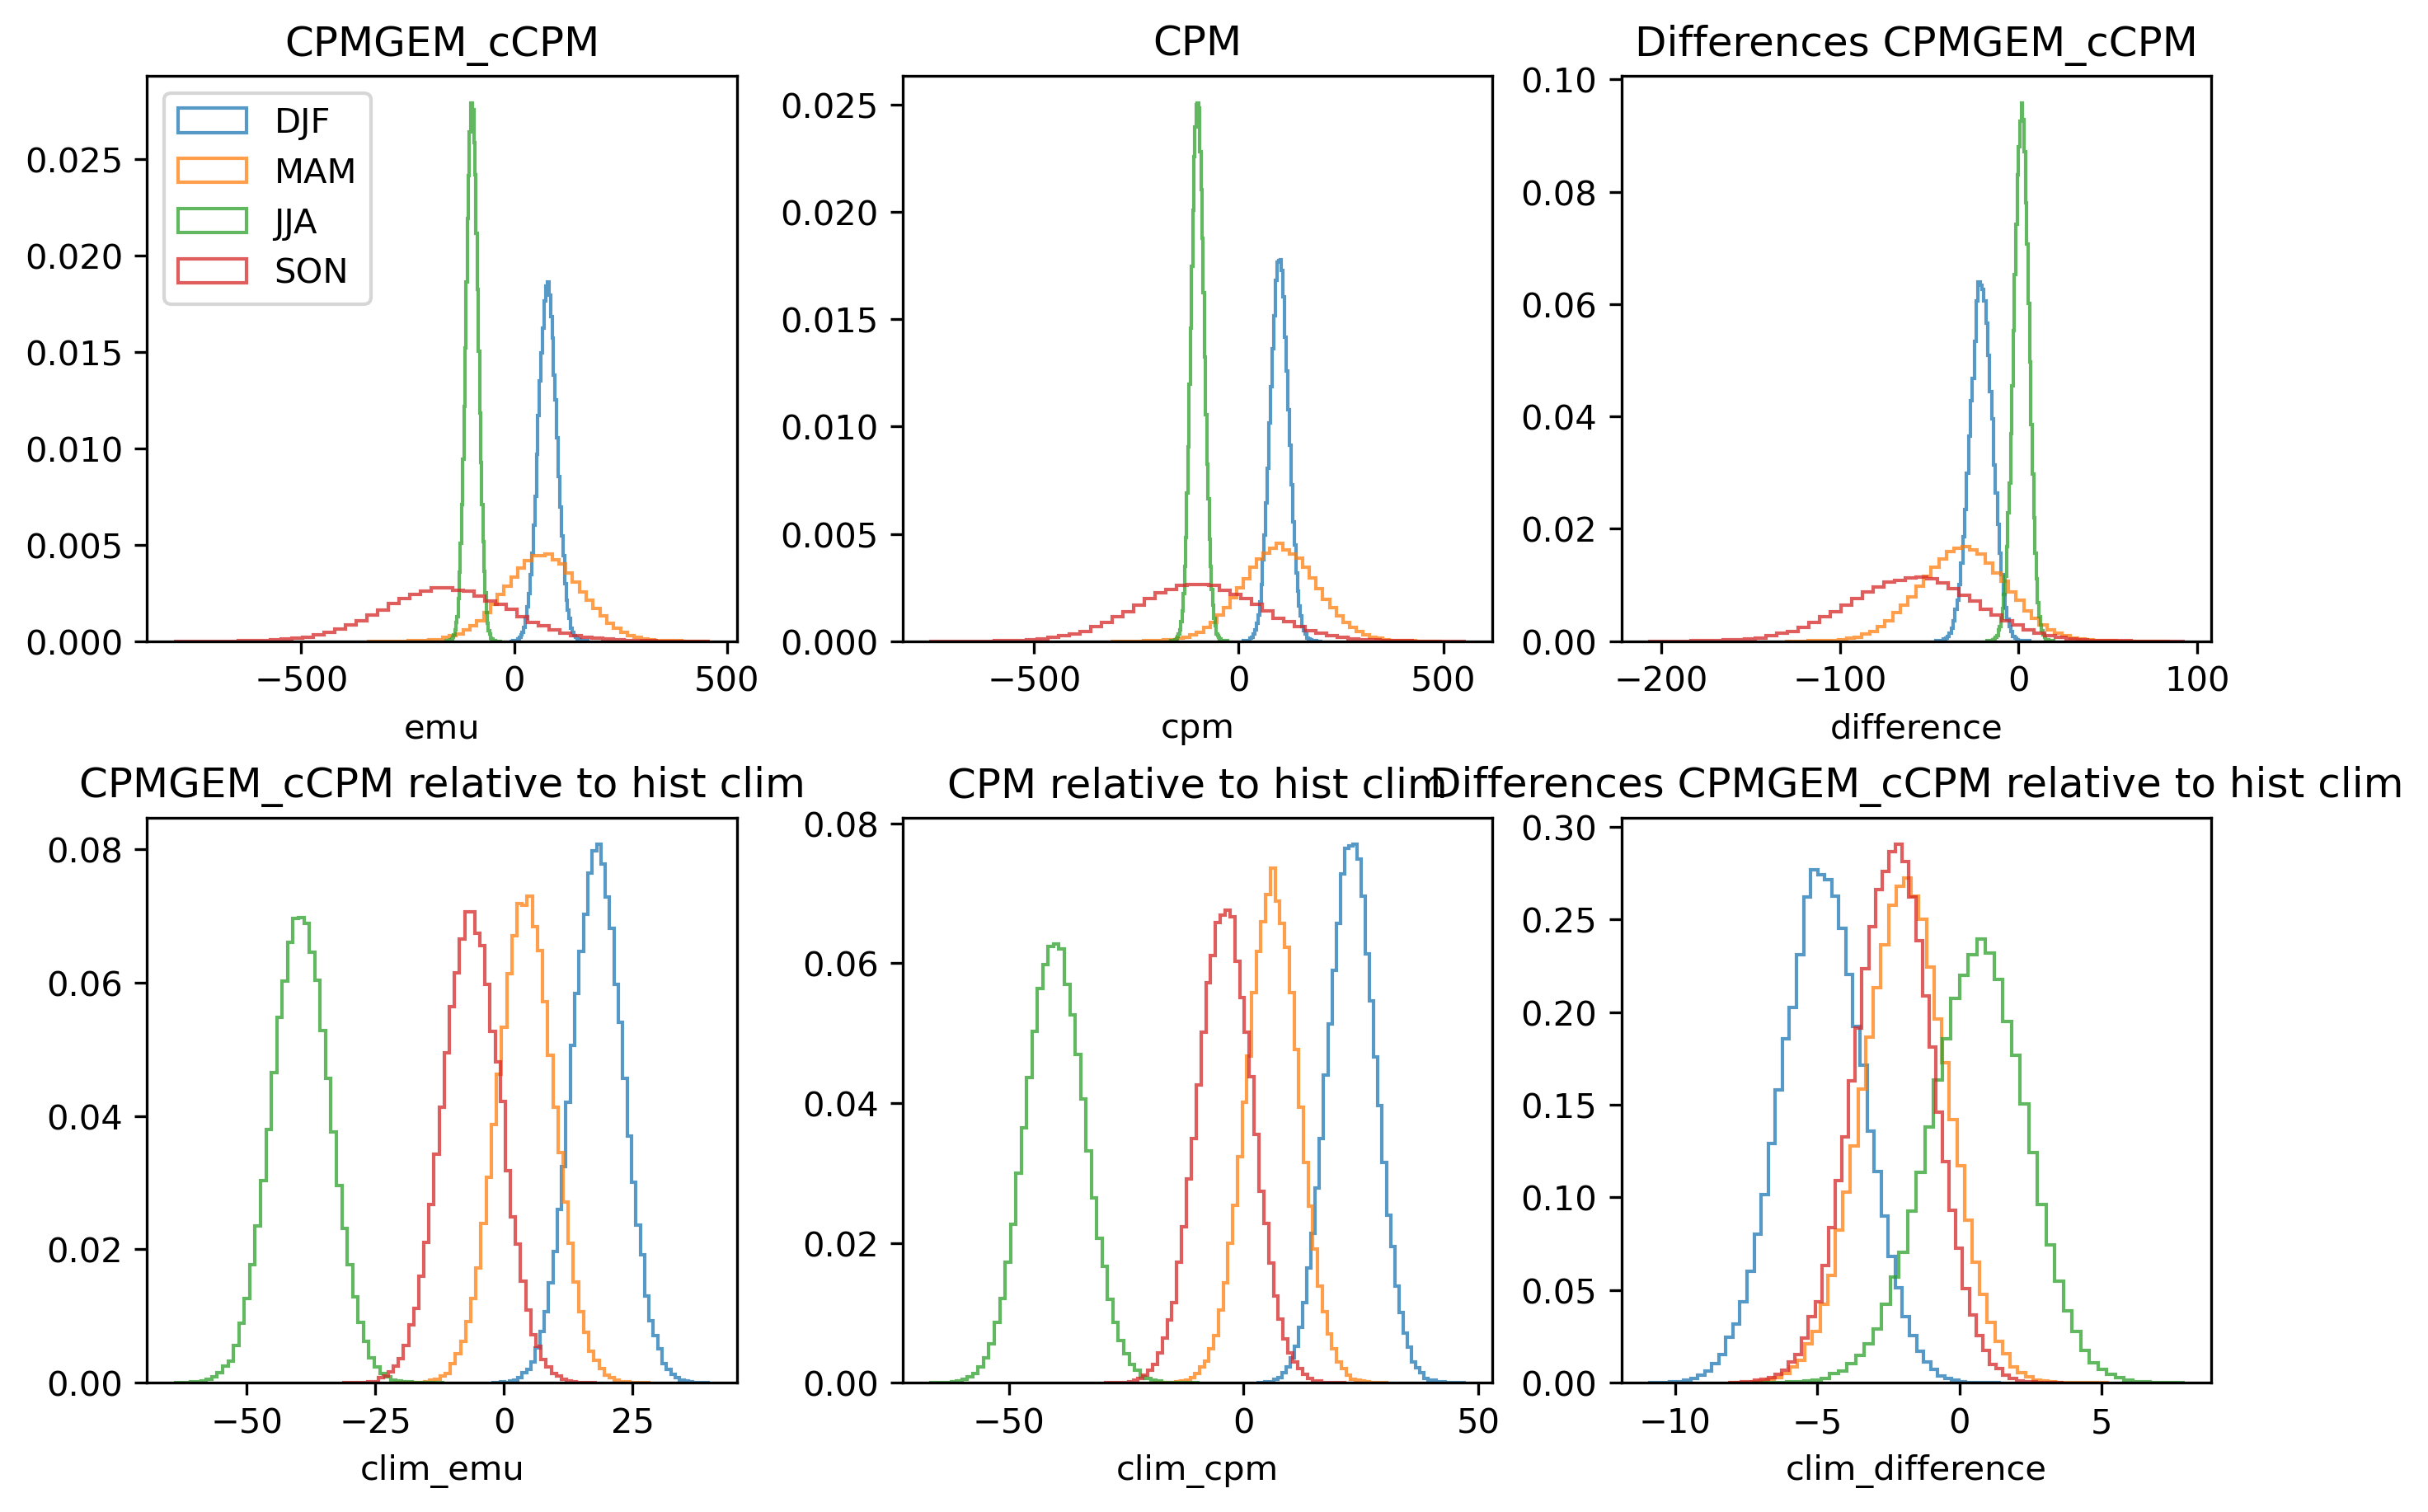

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"#### {var}", raw=True)

    for model, model_ds in CCS_DS.groupby("model"):
        pred_da = model_ds[f"pred_{var}"]
        target_da = model_ds[f"target_{var}"]
        
        IPython.display.display_markdown(f"##### {model}", raw=True)
        fig, axd = plt.subplot_mosaic([["model", "cpm", "difference"], ["clim model", "clim cpm", "clim difference"]], figsize=(9, 6), constrained_layout=True)
        
        seasonal_changes = {}
        for season, season_ds in model_ds.groupby("time.season"):
            if season not in CCS_SEASONS:
                continue
                
            season_cpm_pr = season_ds[f"target_{var}"]
            season_pred_pr = season_ds[f"pred_{var}"].squeeze("model")
            
            hist_season_cpm_pr_mean = (
                season_cpm_pr.where(season_cpm_pr["time_period"] == "historic", drop=True)
                .mean(dim=["grid_latitude", "grid_longitude", "time", "ensemble_member"])
            )
        
            fut_season_cpm_pr_mean = (
                season_cpm_pr.where(season_cpm_pr["time_period"] == "future", drop=True)
                .mean(dim=["grid_latitude", "grid_longitude", "time", "ensemble_member"])
            )
        
            season_cpm_pr_mean_change = fut_season_cpm_pr_mean-hist_season_cpm_pr_mean
            
            hist_mean_samples, fut_mean_samples = bootstrap_seasonal_mean_pr_change_samples(season_cpm_pr, season_pred_pr, nsamples=100_000)

            mean_cpm_change_samples = (100*(fut_mean_samples[f"target_{var}"] - hist_mean_samples[f"target_{var}"])/np.abs(season_cpm_pr_mean_change)).rename("cpm")
            mean_emu_change_samples = (100*(fut_mean_samples[f"pred_{var}"] - hist_mean_samples[f"pred_{var}"])/np.abs(season_cpm_pr_mean_change)).rename("emu")
            differences = (mean_emu_change_samples - mean_cpm_change_samples).rename("difference")            

            clim_mean_cpm_change_samples = (100*(fut_mean_samples[f"target_{var}"] - hist_mean_samples[f"target_{var}"])/np.abs(hist_season_cpm_pr_mean)).rename("clim_cpm")
            clim_mean_emu_change_samples = (100*(fut_mean_samples[f"pred_{var}"] - hist_mean_samples[f"pred_{var}"])/np.abs(hist_season_cpm_pr_mean)).rename("clim_emu")
            clim_differences = (clim_mean_emu_change_samples - clim_mean_cpm_change_samples).rename("clim_difference")            
            
            seasonal_changes[season] = xr.merge([mean_cpm_change_samples, mean_emu_change_samples, differences, clim_mean_cpm_change_samples, clim_mean_emu_change_samples, clim_differences])
            # print(seasonal_changes[season])

        for season in CCS_SEASONS:
            IPython.display.display_markdown(f"###### {season}", raw=True)

            ax = axd["model"]
            seasonal_changes[season]["emu"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            ax.legend()
            ax.set_title(f"{model}")
            
            ax = axd["cpm"]
            seasonal_changes[season]["cpm"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            # ax.legend()
            ax.set_title(f"CPM")

            ax = axd["difference"]
            seasonal_changes[season]["difference"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            # ax.legend()
            ax.set_title(f"Differences {model}")
            
            ax = axd["clim difference"]
            seasonal_changes[season]["clim_difference"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            # ax.legend()
            ax.set_title(f"Differences {model} relative to hist clim")

            ax = axd["clim model"]
            seasonal_changes[season]["clim_emu"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            # ax.legend()
            ax.set_title(f"{model} relative to hist clim")
            
            ax = axd["clim cpm"]
            seasonal_changes[season]["clim_cpm"].plot.hist(bins=50, ax=ax, label=season, alpha=0.75, histtype="step", linewidth=1, density=True)
            # ax.legend()
            ax.set_title(f"CPM relative to hist clim")
        
            alpha = 0.05
            IPython.display.display_html(seasonal_changes[season].quantile([alpha/2, 1-(alpha/2)]).to_dataframe().round(2).to_html(), raw=True)

        plt.show()

In [ ]:
from mlde_analysis import significance

# CCS_SEASONS = ["DJF", "JJA"]
# for season, season_ds in EVAL_DS["GCM"].isel(model=[0]).groupby("time.season"):
#     if season not in CCS_SEASONS:
#         continue
#     fig = plt.figure(figsize=(5.5, 2.5), layout="compressed")
#     axd = fig.subplot_mosaic(np.array(list(TIME_PERIODS.keys())).reshape(1, -1), sharex=True, subplot_kw=dict(projection=cp_model_rotated_pole))
    
#     for tp_idx, tp_key in enumerate(TIME_PERIODS.keys()):
#         tp_season_ds = season_ds.where(season_ds["time_period"] == tp_key, drop=True)

#         for model, ds in tp_season_ds.groupby("model"):
#             ttest_result = significance.significance_test(ds.squeeze())
#             ds["pvalue"] = xr.Variable(["grid_latitude", "grid_longitude"], ttest_result.pvalue)
    
#             N = len(ds["grid_longitude"]) * len(ds["grid_latitude"])
#             alpha_fdr = 0.1
#             pvalue_threshold = alpha_fdr*np.arange(1, N+1, step=1)/N        
#             sorted_pvalues = np.sort(np.ravel(ds["pvalue"]))
#             p_values_less_than_alpha_fdr_frac = np.nonzero(np.cumprod(sorted_pvalues <= pvalue_threshold))[0]
#             if len(p_values_less_than_alpha_fdr_frac) == 0:
#                 # no local tests are below the controlled FDR
#                 p_fdr_star = 0. 
#             else:
#                 idx_star = p_values_less_than_alpha_fdr_frac.max()
#                 p_fdr_star = sorted_pvalues[idx_star]
            
#             ax=axd[tp_key]
#             # plot_map(ds["pvalue"], ax=ax, add_colorbar=True, style=None)
#             plot_map(ds["pvalue"] <= p_fdr_star, ax=ax, add_colorbar=True, style=None, vmin=0, vmax=1)
#             ax.set_title(f"{tp_key}")
#             fig.suptitle(f"{season} {model}")
#     plt.show()